# Linear increasing price

In [1]:
# imports
import numpy as np
np.random.seed(11)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

import pandas as pd
import backtest as twp
from matplotlib import pyplot as plt

from sklearn import metrics, preprocessing

In [2]:
#Load data
def load_data(type_evol='linear'):
    if type_evol == 'linear':
        price = np.arange(200/10.0) #linearly increasing prices
    elif type_evol == 'sin':
        price = np.sin(np.arange(200)/30.0) #sine prices 
    elif type_evol == 'cos':
        price = np.cos(np.arange(200)/30.0)
    elif type_evol == 'random_walk':
        price = [100]
        for i in range(1, 200):
            price.append(price[i-1]* np.exp(0.1* np.random.normal(0,1)))
    return price

In [3]:
np.random.normal(0,1)

1.7494547413051793

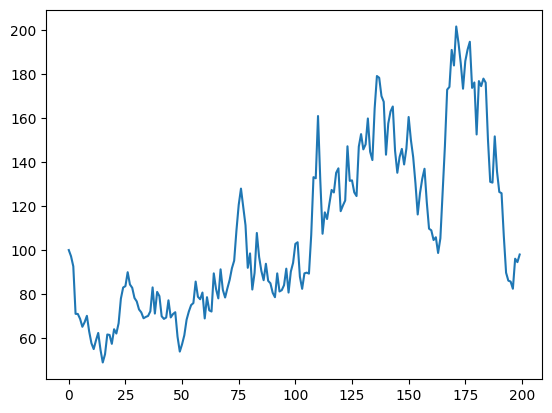

In [4]:
# plot data
plt.plot(load_data(type_evol='random_walk'))

In [5]:
#Initialize first state, all items are placed deterministically
def init_state(data):
    
    close = data
    diff = np.diff(data)
    diff = np.insert(diff, 0, 0)
    
    #--- Preprocess data
    xdata = np.column_stack((close, diff))
    xdata = np.nan_to_num(xdata)
    scaler = preprocessing.StandardScaler()
    xdata = scaler.fit_transform(xdata)
    
    state = xdata[0:1, :]
    return state, xdata

In [6]:
#Take Action
def take_action(state, xdata, action, signal, time_step):
    #this should generate a list of trade signals that at evaluation time are fed to the backtester
    #the backtester should get a list of trade signals and a list of price data for the assett
    
    #make necessary adjustments to state and then return it
    time_step += 1
    
    #if the current iteration is the last state ("terminal state") then set terminal_state to 1
    if time_step == xdata.shape[0]:
        state = xdata[time_step-1:time_step, :]
        terminal_state = 1
        signal.loc[time_step] = 0
        return state, time_step, signal, terminal_state

    #move the market data window one step forward
    state = xdata[time_step-1:time_step, :]
    #take action
    if action != 0:
        if action == 1:
            signal.loc[time_step] = 100
        elif action == 2:
            signal.loc[time_step] = -100
        elif action == 3:
            signal.loc[time_step] = 0
    terminal_state = 0

    return state, time_step, signal, terminal_state

In [7]:
#Get Reward, the reward is returned at the end of an episode
def get_reward(new_state, time_step, action, xdata, signal, terminal_state, epoch=0):
    reward = 0
    signal.fillna(value=0, inplace=True)
    if terminal_state == 0:
        #get reward for the most current action
        if signal[time_step] != signal[time_step-1] and terminal_state == 0:
            i=1
            while signal[time_step-i] == signal[time_step-1-i] and time_step - 1 - i > 0:
                i += 1
            reward = (xdata[time_step-1, 0] - xdata[time_step - i-1, 0]) * signal[time_step - 1]*-100 + i*np.abs(signal[time_step - 1])/10.0
        if signal[time_step] == 0 and signal[time_step - 1] == 0:
            reward -= 10

    #calculate the reward for all actions if the last iteration in set
    if terminal_state == 1:
        #run backtest, send list of trade signals and asset data to backtest function
        bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
        reward = bt.pnl.iloc[-1]

    return reward

In [8]:
def evaluate_Q(eval_data, eval_model):
    #This function is used to evaluate the perofrmance of the system each epoch, without the influence of epsilon and random actions
    signal = pd.Series(index=np.arange(len(eval_data)))
    state, xdata = init_state(eval_data)
    status = 1
    terminal_state = 0
    time_step = 1
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = eval_model.predict(state.reshape(1,2), batch_size=1)
        action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        eval_reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
    return eval_reward

In [9]:
#This neural network is the Q-function, run it like this:
#model.predict(state.reshape(1,64), batch_size=1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(4, kernel_initializer='lecun_uniform', input_shape=(2,)))
model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

model.add(Dense(4, kernel_initializer='lecun_uniform'))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(4, kernel_initializer='lecun_uniform'))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

In [10]:
import random, timeit

start_time = timeit.default_timer()

indata = load_data(type_evol='cos')
epochs = 50
gamma = 0.9 #a high gamma makes a long-term reward more valuable
epsilon = 1
learning_progress = []
#stores tuples of (S, A, R, S')
h = 0
signal = pd.Series(index=np.arange(len(indata)))
for i in range(epochs):

    state, xdata = init_state(indata)
    status = 1
    terminal_state = 0
    time_step = 1
    #while learning is still in progress
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = model.predict(state.reshape(1,2), batch_size=1)
        if (random.random() < epsilon) and i != epochs - 1: #maybe choose random action if not the last epoch
            action = np.random.randint(0,4) #assumes 4 different actions
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        #Get max_Q(S',a)
        newQ = model.predict(new_state.reshape(1,2), batch_size=1)
        maxQ = np.max(newQ)
        y = np.zeros((1,4))
        y[:] = qval[:]
        if terminal_state == 0: #non-terminal state
            update = (reward + (gamma * maxQ))
        else: #terminal state (means that it is the last state)
            update = reward
        y[0][action] = update #target output
        model.fit(state.reshape(1,2), y, batch_size=1, epochs=1, verbose=0)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
    eval_reward = evaluate_Q(indata, model)
    print("Epoch #: %s Reward: %f Epsilon: %f" % (i,eval_reward, epsilon))
    learning_progress.append((eval_reward))
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

1/1 [==============================] - 0s 7ms/step
Epoch #: 0 Reward: 31.387359 Epsilon: 1.000000
1/1 [==============================] - 0s 8ms/step
Epoch #: 1 Reward: 168.932139 Epsilon: 0.980000
1/1 [==============================] - 0s 7ms/step
Epoch #: 2 Reward: 182.600311 Epsilon: 0.960000
1/1 [==============================] - 0s 7ms/step
Epoch #: 3 Reward: 271.529109 Epsilon: 0.940000
1/1 [==============================] - 0s 7ms/step
Epoch #: 4 Reward: 311.548593 Epsilon: 0.920000
1/1 [==============================] - 0s 8ms/step
Epoch #: 5 Reward: 330.698481 Epsilon: 0.900000
1/1 [==============================] - 0s 7ms/step
Epoch #: 6 Reward: 362.778029 Epsilon: 0.880000
1/1 [==============================] - 0s 8ms/step
Epoch #: 7 Reward: 306.261760 Epsilon: 0.860000
1/1 [==============================] - 0s 7ms/step
Epoch #: 8 Reward: 320.062477 Epsilon: 0.840000
1/1 [==============================] - 0s 9ms/step
Epoch #: 9 Reward: 471.558757 Epsilon: 0.820000
1/1 [======

        price  shares       value        cash         pnl  delta
0    1.304677     0.0    0.000000    0.000000    0.000000    0.0
1    1.303909     0.0    0.000000    0.000000    0.000000    0.0
2    1.301606   100.0  130.160598 -130.160598    0.000000  100.0
3    1.297770   100.0  129.777029 -130.160598   -0.383569    0.0
4    1.292406  -100.0 -129.240629  128.320661   -0.919968 -200.0
..        ...     ...         ...         ...         ...    ...
195  1.272309  -100.0 -127.230922  673.994606  546.763685    0.0
196  1.261648  -100.0 -126.164752  673.994606  547.829855    0.0
197  1.249498  -100.0 -124.949764  673.994606  549.044842    0.0
198  1.235873  -100.0 -123.587309  673.994606  550.407298    0.0
199  1.220789  -100.0 -122.078900  673.994606  551.915707    0.0

[200 rows x 6 columns]


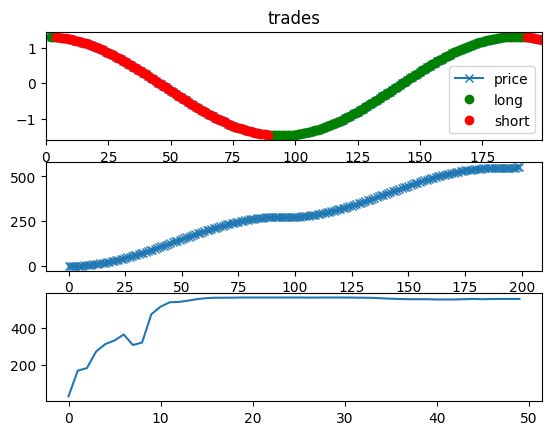

In [11]:
#plot results
bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

print(bt.data)

plt.figure()
bt.plotTrades()
plt.suptitle('epoch' + str(i))
# plt.savefig('plt/final_trades'+'.png', bbox_inches='tight', pad_inches=1, dpi=72) #assumes there is a ./plt dir
plt.close('all')

plt.figure()
plt.subplot(3,1,1)
bt.plotTrades()
plt.subplot(3,1,2)
bt.pnl.plot(style='x-')
plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.show()